In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils2 import Logger

### Import dataset

In [22]:
batch_size_train = 150

data_dir = 'data/'

image_loader = torch.utils.data.DataLoader(
  datasets.MNIST(data_dir, train=True, download=True,
                             transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((.5), (.5))
                             ])),
  batch_size=batch_size_train, shuffle=True)

# Num batches
num_batches = len(image_loader)

### Defining networks

In [23]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
        )
        self.hidden1 = nn.Sequential(
            nn.Conv2d(10, 20, kernel_size=5),
            nn.MaxPool2d(2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(320, 50),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(50, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = x.view(-1, 320)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    

In [53]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        
        #Apply a resNet like sum after linear 
        self.short1 = nn.Conv2d(100, 540, kernel_size=1, stride=1, bias=False)
        self.leakyrelu = nn.LeakyReLU(0.2)
        
        self.linear1 = nn.Sequential(
            nn.Linear(n_features, 200),
            nn.LeakyReLU(0.2)
        )
        
        self.linear2 = nn.Linear(200, 540)
        
        self.conv1 = nn.Sequential(            
            nn.ConvTranspose2d(15, 10, kernel_size=10),
            nn.LeakyReLU(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(10, 1, kernel_size=14),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        original_x = x
        x = self.linear1(x)
        x = self.linear2(x)
        shortcut = self.short1(original_x.view(-1, 100, 1, 1))
        x = x + shortcut.view(-1, 540)
        x = self.leakyrelu(x)
        x = x.view(-1, 15, 6, 6)
        x = self.conv1(x)
        x = self.conv2(x)
        return x
    

In [55]:
#This is just a test
tensor_test = torch.rand(100)
linear1 = nn.Linear(100, 200)
linear2 = nn.Linear(200, 540)

shrt = nn.Conv2d(100, 540, kernel_size=1, stride=1, bias=False)

conv1 = nn.ConvTranspose2d(15, 10, kernel_size=10)
conv2 = nn.ConvTranspose2d(10, 1, kernel_size=14)

out = linear1(tensor_test)
out = linear2(out)
shortcut = shrt(tensor_test.view(1,100,1,1))
out = out + shortcut.view(-1)
out = out.view(-1, 15, 6, 6)

out = conv1(out)
#out = conv2(out)
out.shape


torch.Size([1, 10, 15, 15])

### Helper functions

In [56]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

### Training

In [57]:
#check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [58]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

generator.to(device)
discriminator.to(device)

#Define loss function and both optimizer functions
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
#d_optimizer = optim.Adam(discriminator.parameters(), lr=0.002)
#g_optimizer = optim.Adam(generator.parameters(), lr=0.002)
loss = nn.BCELoss()

In [59]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N).to(device) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N).to(device))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [60]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    #Send data to device
    fake_data = fake_data.to(device)
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N).to(device))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [61]:
num_test_samples = 16
test_noise = noise(num_test_samples).to(device)

In [62]:
#Test here
#fake_data = generator(noise(3).to(device)).detach()

#n_batch, (real_batch,_) = next(enumerate(image_loader))
#real_batch.shape

#plt.imshow(fake_data[0][0].cpu().detach().numpy(), cmap='gray', interpolation='none')

C:\Users\uidj9930\Miniconda3\envs\torch_examples\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


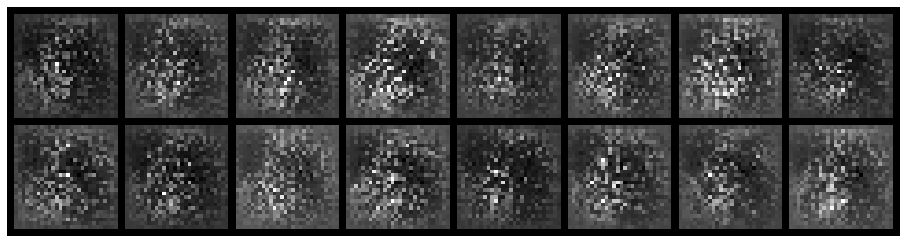

Epoch: [0/100], Batch Num: [0/400]
Discriminator Loss: 1.4055, Generator Loss: 0.6478
D(x): 0.5134, D(G(z)): 0.5218


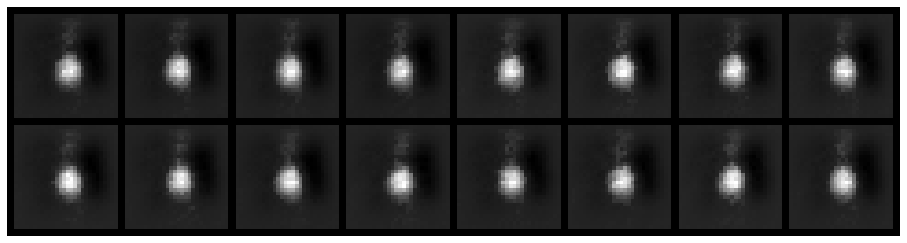

Epoch: [0/100], Batch Num: [100/400]
Discriminator Loss: 1.1365, Generator Loss: 0.5423
D(x): 0.7859, D(G(z)): 0.5897


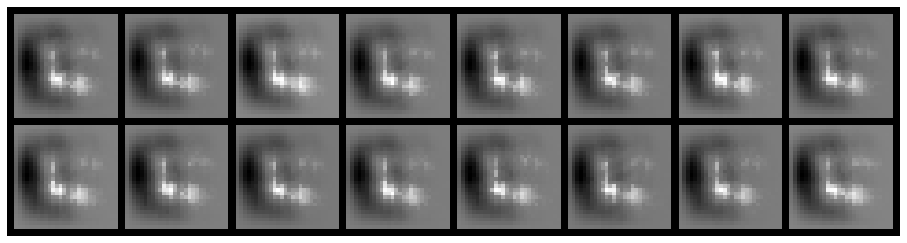

Epoch: [0/100], Batch Num: [200/400]
Discriminator Loss: 0.4253, Generator Loss: 1.8129
D(x): 0.8633, D(G(z)): 0.2206


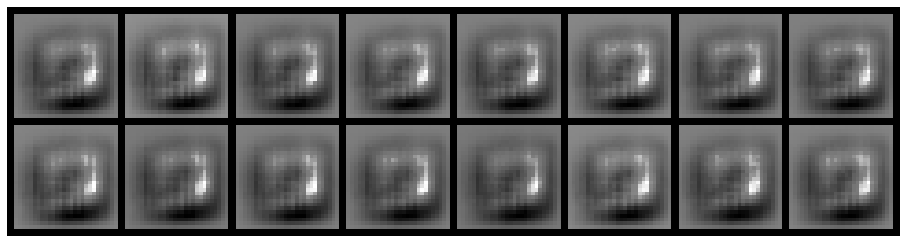

Epoch: [0/100], Batch Num: [300/400]
Discriminator Loss: 0.8529, Generator Loss: 1.8674
D(x): 0.5834, D(G(z)): 0.2406


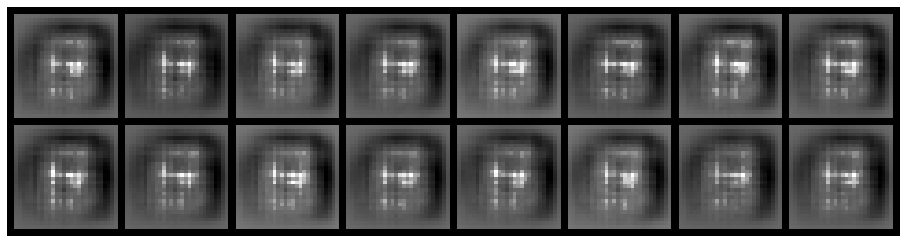

Epoch: [1/100], Batch Num: [0/400]
Discriminator Loss: 1.7297, Generator Loss: 0.4939
D(x): 0.5216, D(G(z)): 0.6204


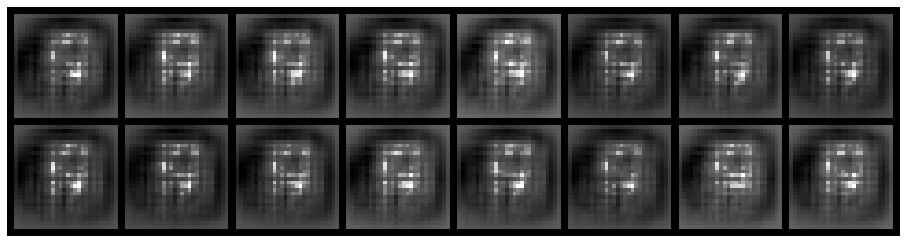

Epoch: [1/100], Batch Num: [100/400]
Discriminator Loss: 1.1309, Generator Loss: 0.7606
D(x): 0.6716, D(G(z)): 0.4825


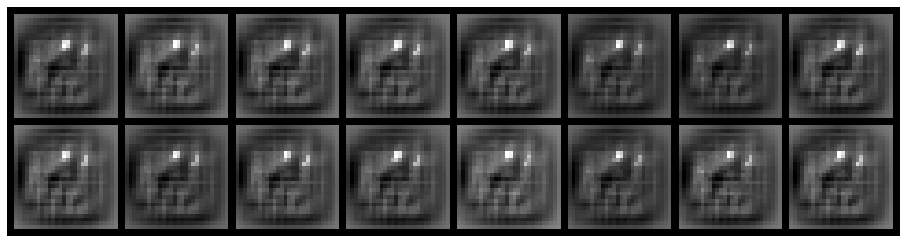

Epoch: [1/100], Batch Num: [200/400]
Discriminator Loss: 1.5387, Generator Loss: 1.0694
D(x): 0.3706, D(G(z)): 0.3727


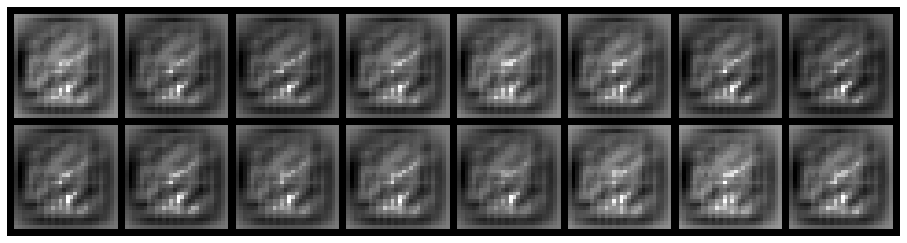

Epoch: [1/100], Batch Num: [300/400]
Discriminator Loss: 1.4007, Generator Loss: 0.8470
D(x): 0.4637, D(G(z)): 0.4463


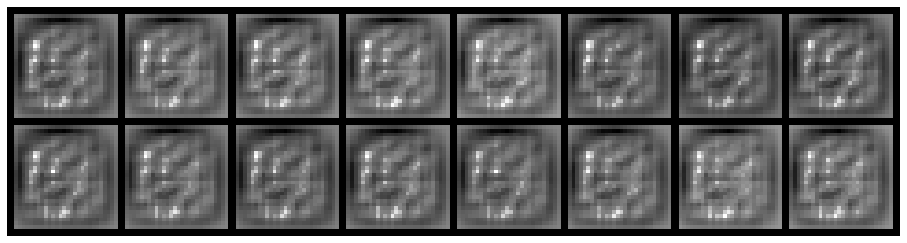

Epoch: [2/100], Batch Num: [0/400]
Discriminator Loss: 1.3036, Generator Loss: 0.7850
D(x): 0.5048, D(G(z)): 0.4537


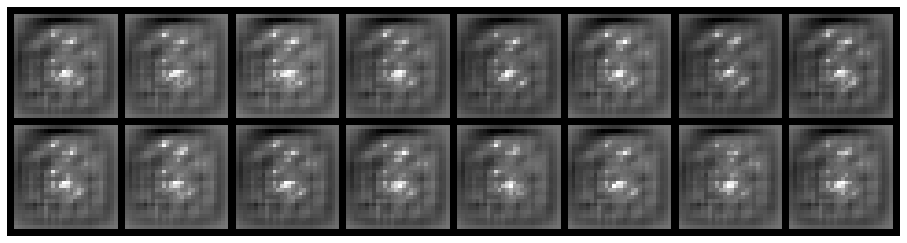

Epoch: [2/100], Batch Num: [100/400]
Discriminator Loss: 1.1073, Generator Loss: 0.7972
D(x): 0.6307, D(G(z)): 0.4645


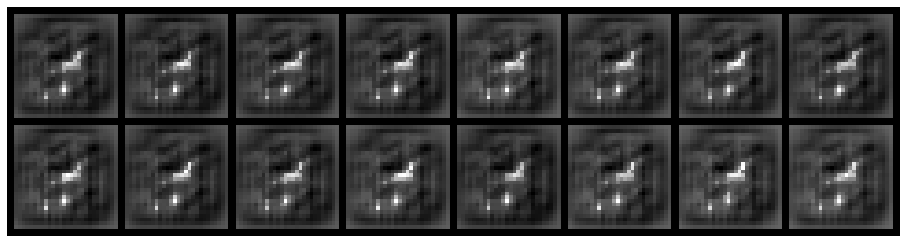

Epoch: [2/100], Batch Num: [200/400]
Discriminator Loss: 1.1094, Generator Loss: 1.0171
D(x): 0.5631, D(G(z)): 0.3833


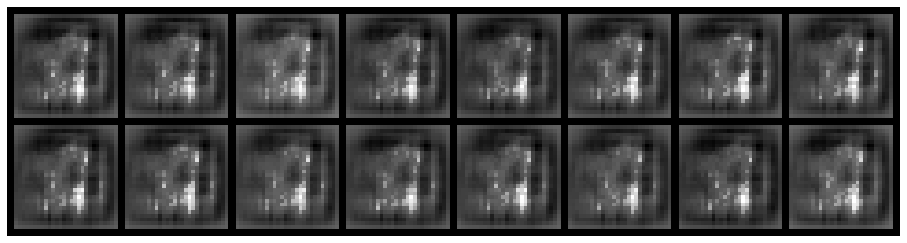

Epoch: [2/100], Batch Num: [300/400]
Discriminator Loss: 1.0310, Generator Loss: 0.7119
D(x): 0.8231, D(G(z)): 0.5519


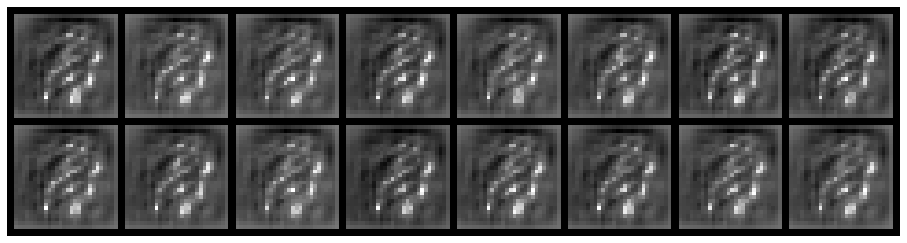

Epoch: [3/100], Batch Num: [0/400]
Discriminator Loss: 1.1762, Generator Loss: 0.9526
D(x): 0.6289, D(G(z)): 0.4310


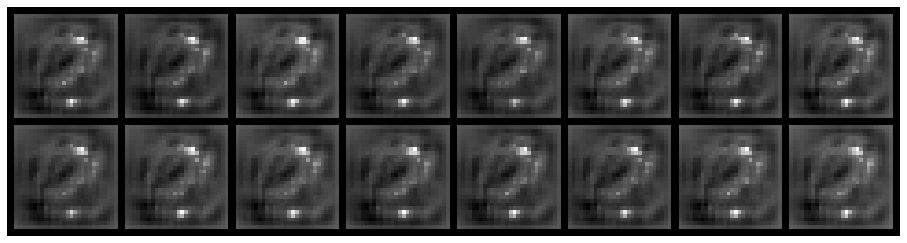

Epoch: [3/100], Batch Num: [100/400]
Discriminator Loss: 1.3284, Generator Loss: 0.8865
D(x): 0.5759, D(G(z)): 0.4692


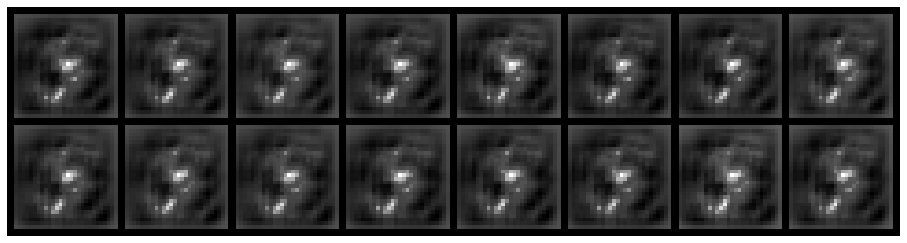

Epoch: [3/100], Batch Num: [200/400]
Discriminator Loss: 1.1013, Generator Loss: 1.2302
D(x): 0.5308, D(G(z)): 0.3334


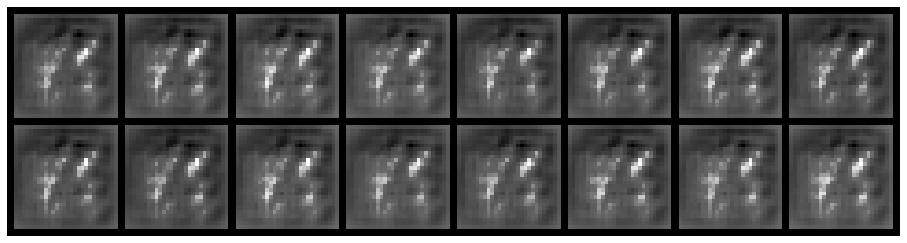

Epoch: [3/100], Batch Num: [300/400]
Discriminator Loss: 1.0539, Generator Loss: 1.1301
D(x): 0.6584, D(G(z)): 0.4156


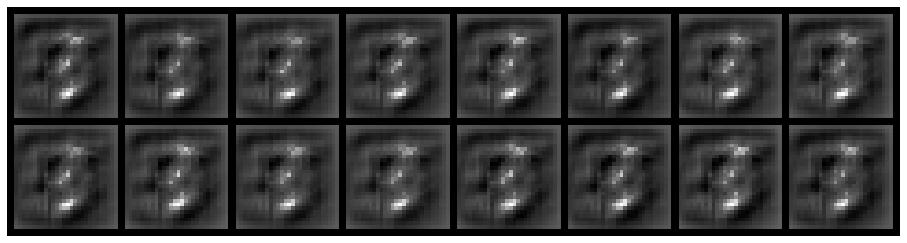

Epoch: [4/100], Batch Num: [0/400]
Discriminator Loss: 1.0925, Generator Loss: 1.4125
D(x): 0.5866, D(G(z)): 0.3304


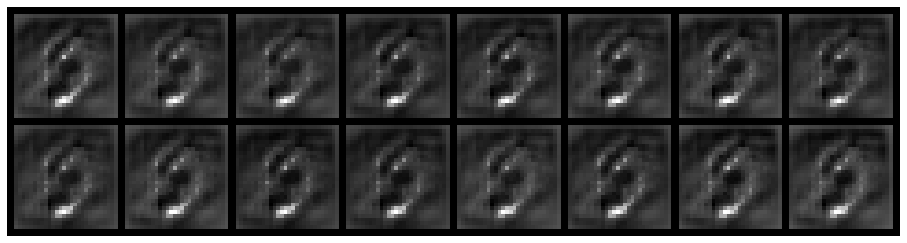

Epoch: [4/100], Batch Num: [100/400]
Discriminator Loss: 1.0070, Generator Loss: 1.4440
D(x): 0.6267, D(G(z)): 0.3042


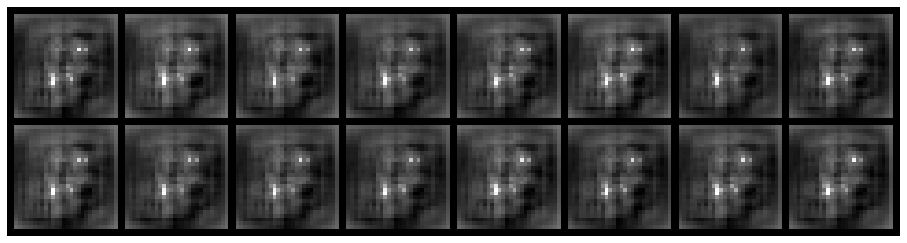

Epoch: [4/100], Batch Num: [200/400]
Discriminator Loss: 0.8414, Generator Loss: 1.3240
D(x): 0.7037, D(G(z)): 0.3189


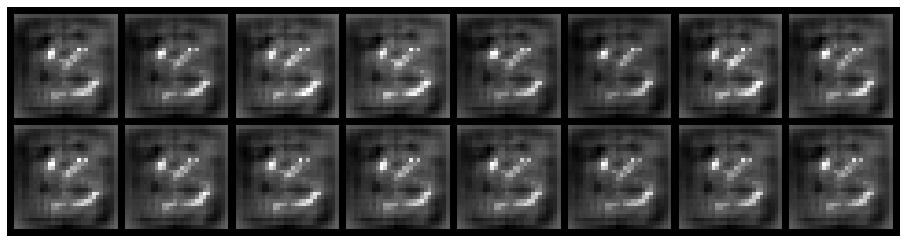

Epoch: [4/100], Batch Num: [300/400]
Discriminator Loss: 0.8486, Generator Loss: 1.0392
D(x): 0.7589, D(G(z)): 0.3998


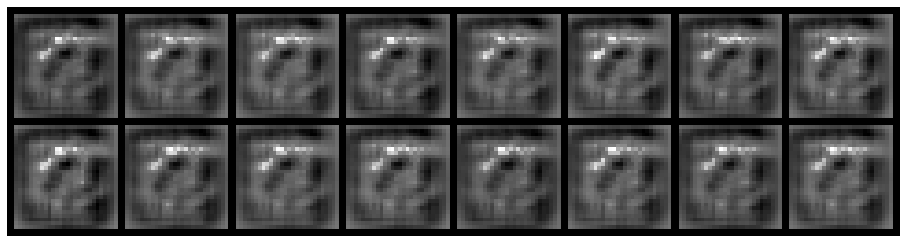

Epoch: [5/100], Batch Num: [0/400]
Discriminator Loss: 0.8420, Generator Loss: 1.2040
D(x): 0.7324, D(G(z)): 0.3423


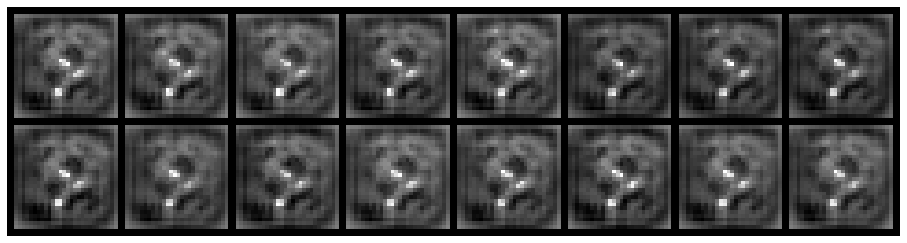

Epoch: [5/100], Batch Num: [100/400]
Discriminator Loss: 0.6323, Generator Loss: 1.6094
D(x): 0.7627, D(G(z)): 0.2421


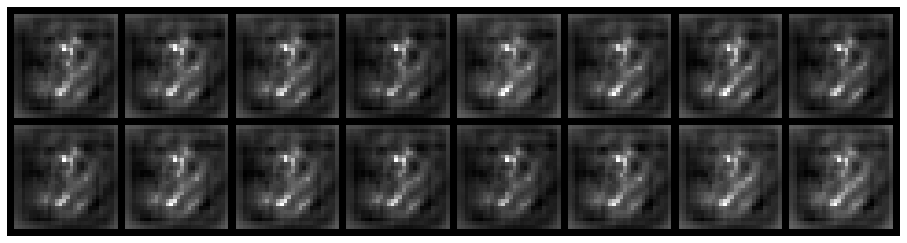

Epoch: [5/100], Batch Num: [200/400]
Discriminator Loss: 0.9652, Generator Loss: 1.2885
D(x): 0.6781, D(G(z)): 0.3296


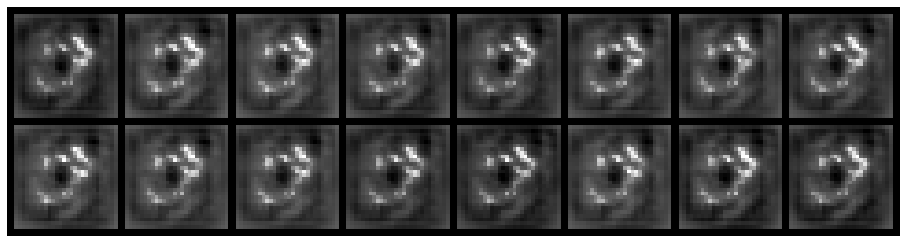

Epoch: [5/100], Batch Num: [300/400]
Discriminator Loss: 0.3919, Generator Loss: 1.8135
D(x): 0.8776, D(G(z)): 0.1918


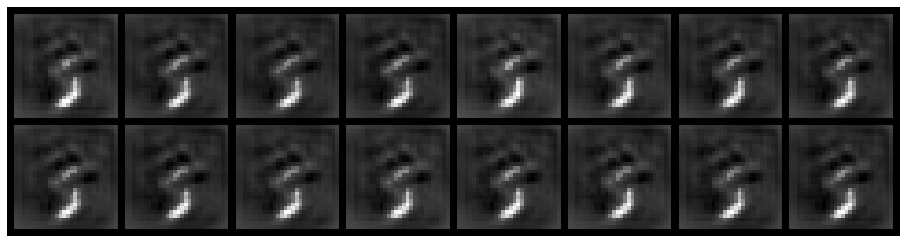

Epoch: [6/100], Batch Num: [0/400]
Discriminator Loss: 1.6137, Generator Loss: 4.0051
D(x): 0.3793, D(G(z)): 0.1236


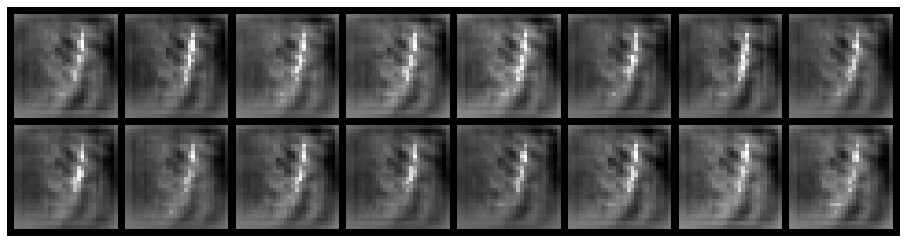

Epoch: [6/100], Batch Num: [100/400]
Discriminator Loss: 0.3980, Generator Loss: 1.9067
D(x): 0.8764, D(G(z)): 0.1887


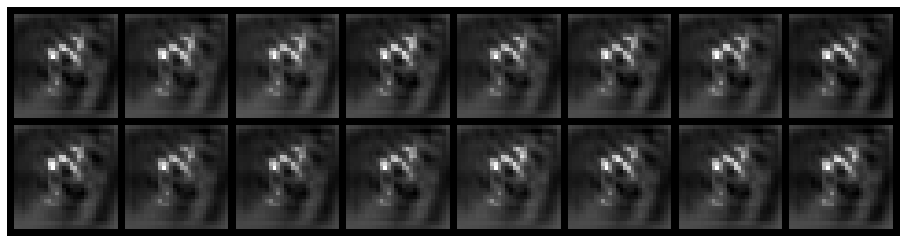

Epoch: [6/100], Batch Num: [200/400]
Discriminator Loss: 0.7119, Generator Loss: 2.8322
D(x): 0.7613, D(G(z)): 0.1940


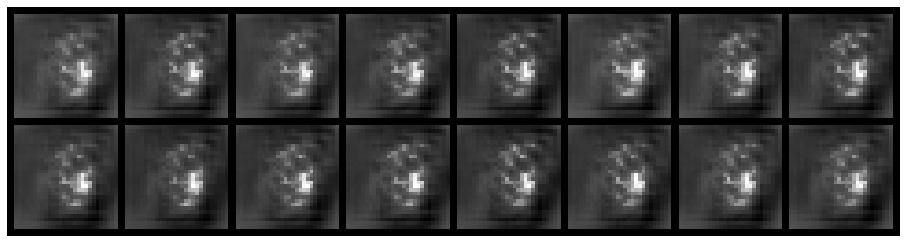

Epoch: [6/100], Batch Num: [300/400]
Discriminator Loss: 0.4839, Generator Loss: 2.2862
D(x): 0.8376, D(G(z)): 0.1777


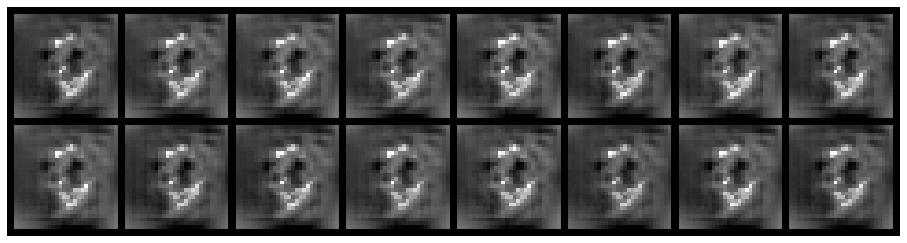

Epoch: [7/100], Batch Num: [0/400]
Discriminator Loss: 0.3426, Generator Loss: 2.7084
D(x): 0.8754, D(G(z)): 0.1281


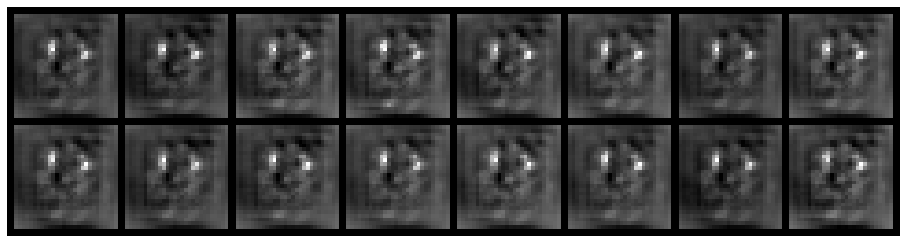

Epoch: [7/100], Batch Num: [100/400]
Discriminator Loss: 0.3249, Generator Loss: 2.6496
D(x): 0.8834, D(G(z)): 0.1181


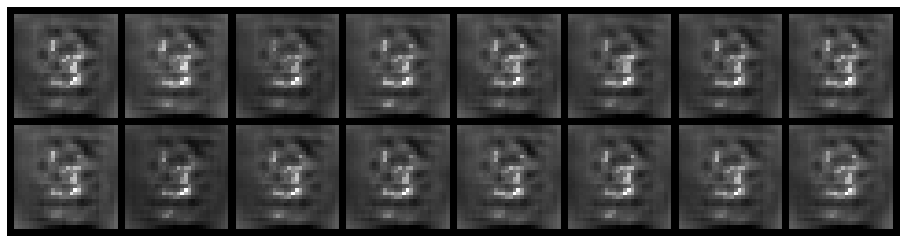

Epoch: [7/100], Batch Num: [200/400]
Discriminator Loss: 0.3758, Generator Loss: 2.4421
D(x): 0.8886, D(G(z)): 0.1337


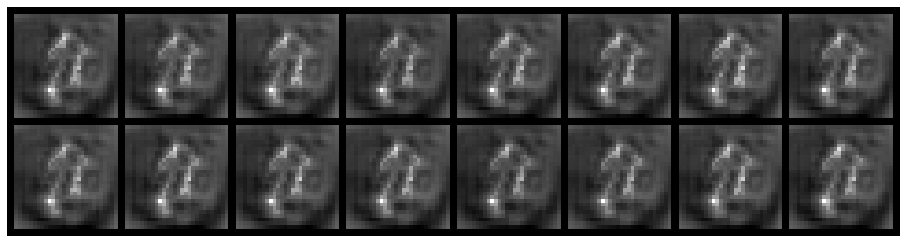

Epoch: [7/100], Batch Num: [300/400]
Discriminator Loss: 0.6193, Generator Loss: 2.6092
D(x): 0.7791, D(G(z)): 0.1597


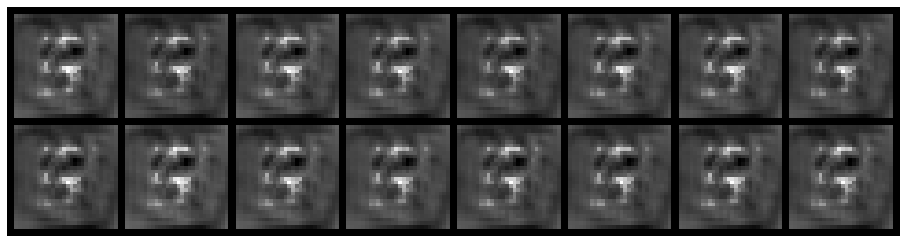

Epoch: [8/100], Batch Num: [0/400]
Discriminator Loss: 0.7694, Generator Loss: 3.5960
D(x): 0.7206, D(G(z)): 0.1365


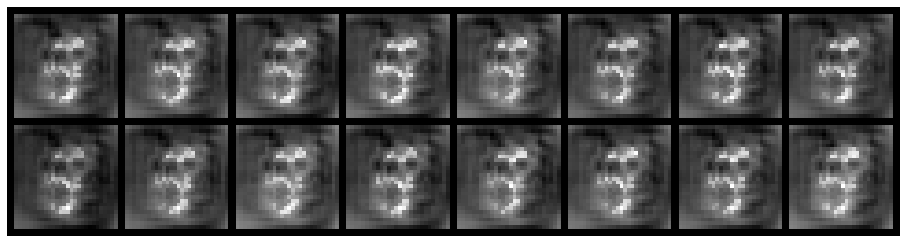

Epoch: [8/100], Batch Num: [100/400]
Discriminator Loss: 0.1870, Generator Loss: 2.9360
D(x): 0.9276, D(G(z)): 0.0760


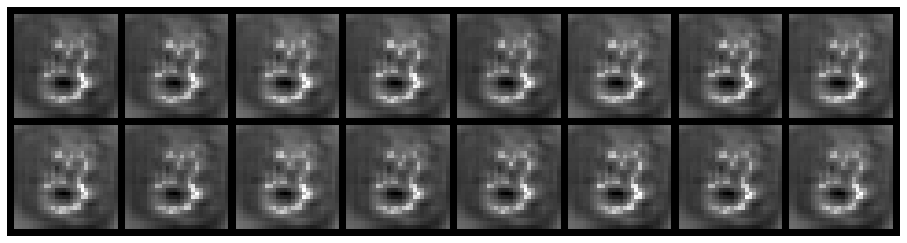

Epoch: [8/100], Batch Num: [200/400]
Discriminator Loss: 0.3324, Generator Loss: 3.3220
D(x): 0.8694, D(G(z)): 0.1001


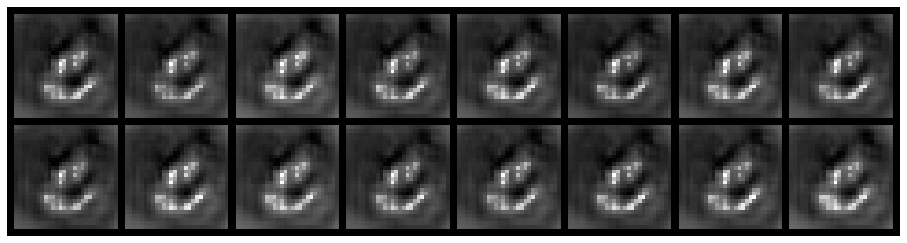

Epoch: [8/100], Batch Num: [300/400]
Discriminator Loss: 0.3004, Generator Loss: 4.3235
D(x): 0.8643, D(G(z)): 0.0371


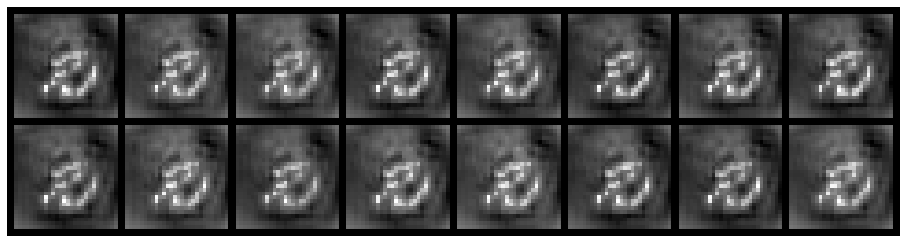

Epoch: [9/100], Batch Num: [0/400]
Discriminator Loss: 0.1976, Generator Loss: 3.0734
D(x): 0.9453, D(G(z)): 0.0787


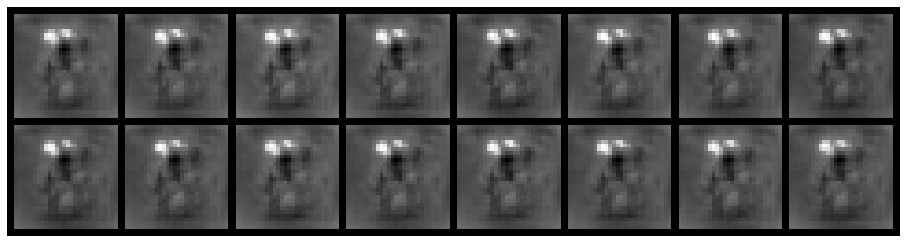

Epoch: [9/100], Batch Num: [100/400]
Discriminator Loss: 0.0479, Generator Loss: 4.2936
D(x): 0.9942, D(G(z)): 0.0363


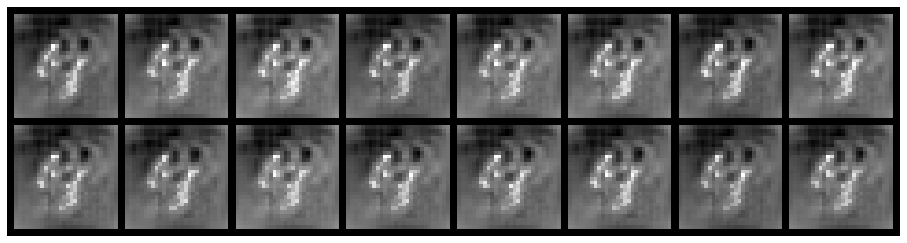

Epoch: [9/100], Batch Num: [200/400]
Discriminator Loss: 0.3025, Generator Loss: 3.7398
D(x): 0.8816, D(G(z)): 0.0746


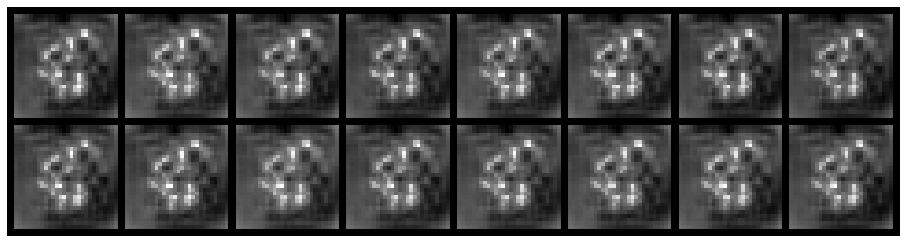

Epoch: [9/100], Batch Num: [300/400]
Discriminator Loss: 0.2003, Generator Loss: 3.0882
D(x): 0.9307, D(G(z)): 0.0896


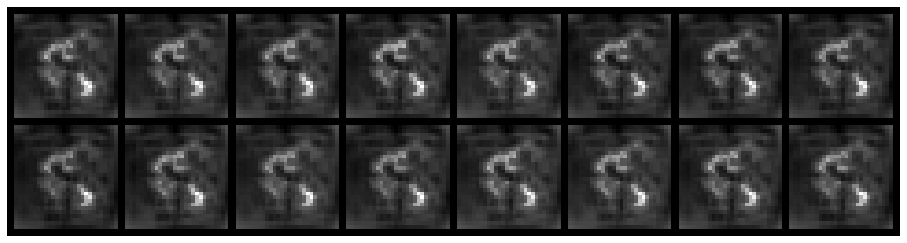

Epoch: [10/100], Batch Num: [0/400]
Discriminator Loss: 0.1241, Generator Loss: 3.0349
D(x): 0.9693, D(G(z)): 0.0794


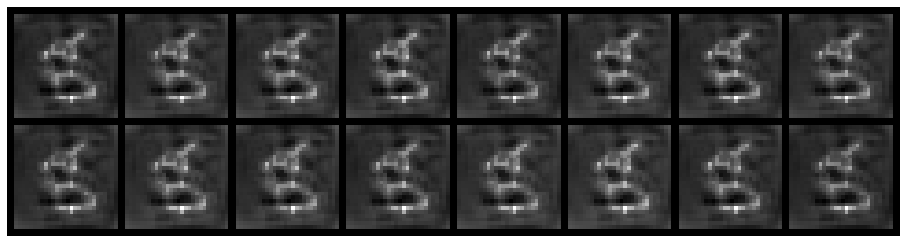

Epoch: [10/100], Batch Num: [100/400]
Discriminator Loss: 0.3091, Generator Loss: 3.3220
D(x): 0.8994, D(G(z)): 0.0895


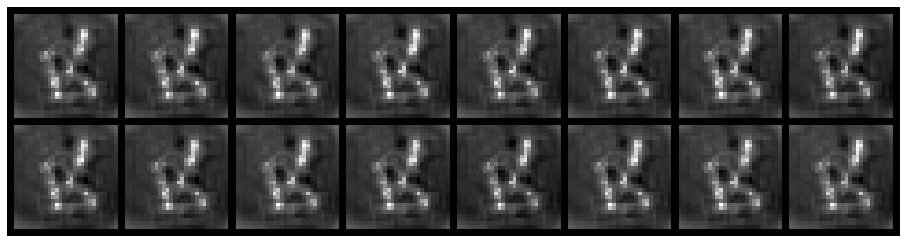

Epoch: [10/100], Batch Num: [200/400]
Discriminator Loss: 0.1602, Generator Loss: 3.6023
D(x): 0.9434, D(G(z)): 0.0473


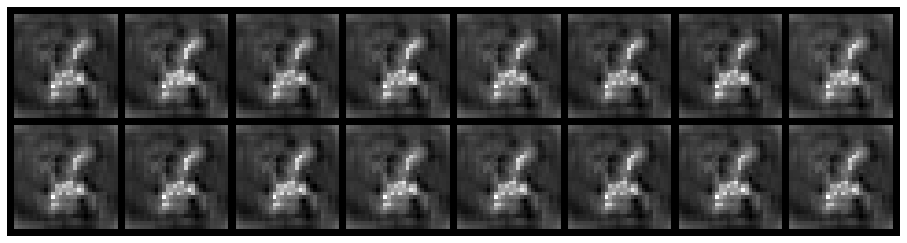

Epoch: [10/100], Batch Num: [300/400]
Discriminator Loss: 0.1553, Generator Loss: 3.4938
D(x): 0.9429, D(G(z)): 0.0606


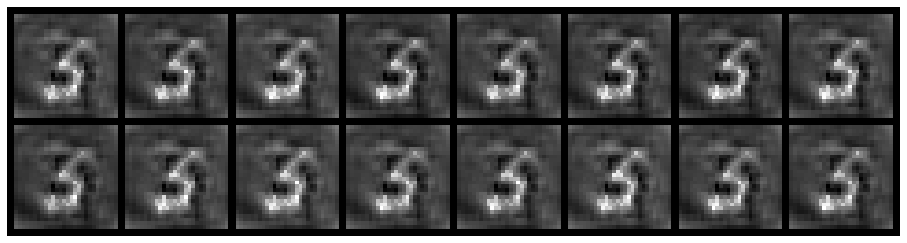

Epoch: [11/100], Batch Num: [0/400]
Discriminator Loss: 0.2669, Generator Loss: 3.8195
D(x): 0.8959, D(G(z)): 0.0532


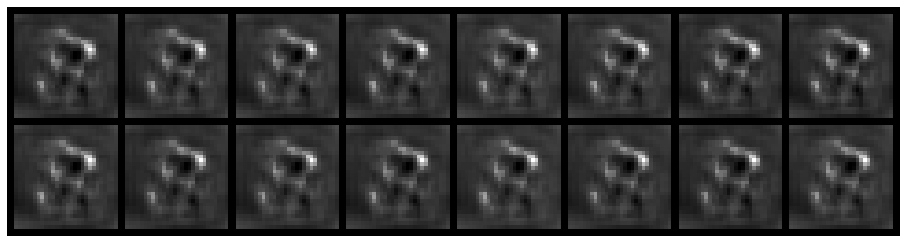

Epoch: [11/100], Batch Num: [100/400]
Discriminator Loss: 0.4806, Generator Loss: 3.6840
D(x): 0.9220, D(G(z)): 0.1605


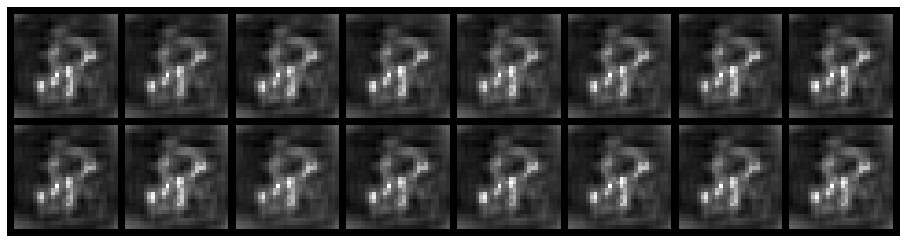

Epoch: [11/100], Batch Num: [200/400]
Discriminator Loss: 0.1918, Generator Loss: 3.7810
D(x): 0.9253, D(G(z)): 0.0483


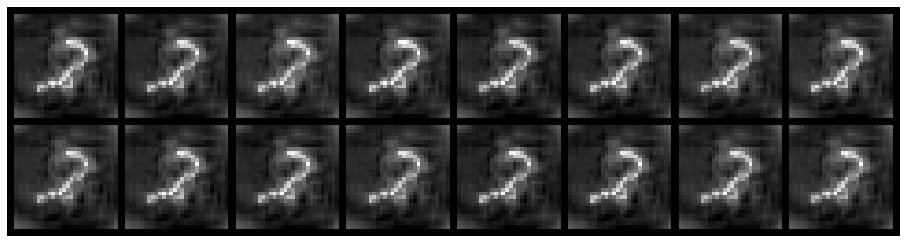

Epoch: [11/100], Batch Num: [300/400]
Discriminator Loss: 0.0895, Generator Loss: 4.2489
D(x): 0.9696, D(G(z)): 0.0315


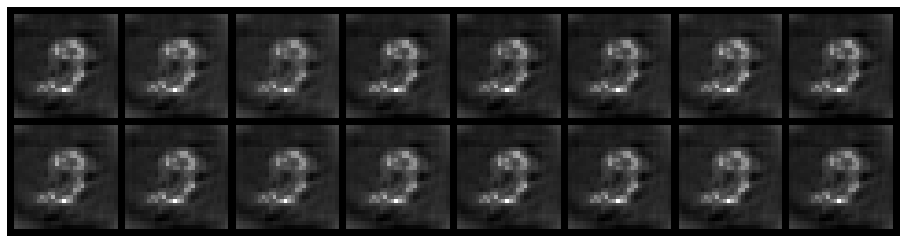

Epoch: [12/100], Batch Num: [0/400]
Discriminator Loss: 0.0923, Generator Loss: 4.2207
D(x): 0.9671, D(G(z)): 0.0361


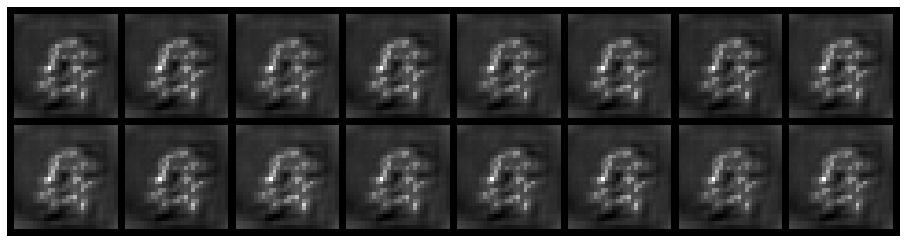

Epoch: [12/100], Batch Num: [100/400]
Discriminator Loss: 0.3950, Generator Loss: 4.1210
D(x): 0.8887, D(G(z)): 0.0913


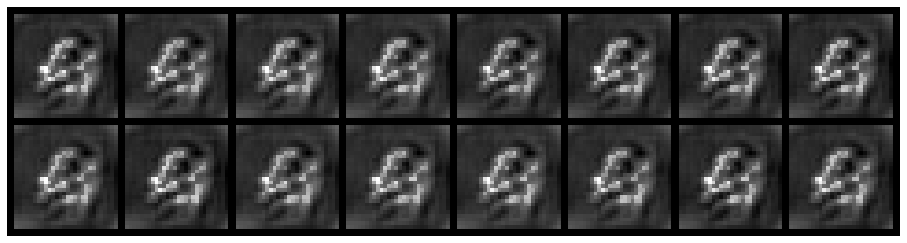

Epoch: [12/100], Batch Num: [200/400]
Discriminator Loss: 0.1438, Generator Loss: 3.8680
D(x): 0.9579, D(G(z)): 0.0502


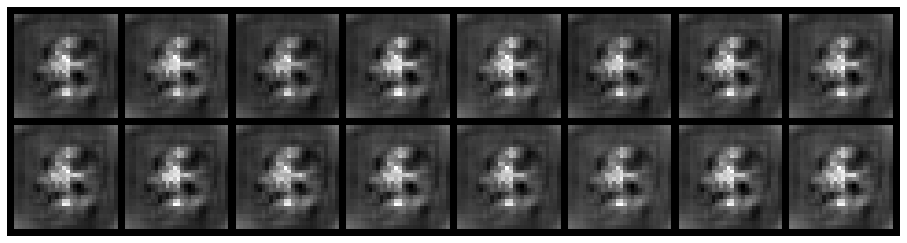

Epoch: [12/100], Batch Num: [300/400]
Discriminator Loss: 0.2186, Generator Loss: 3.8188
D(x): 0.9420, D(G(z)): 0.0558


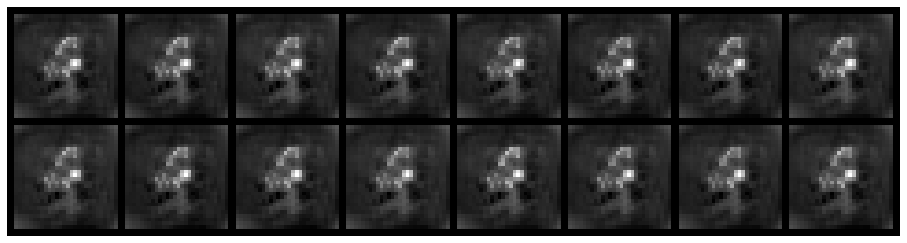

Epoch: [13/100], Batch Num: [0/400]
Discriminator Loss: 0.0781, Generator Loss: 3.7325
D(x): 0.9728, D(G(z)): 0.0404


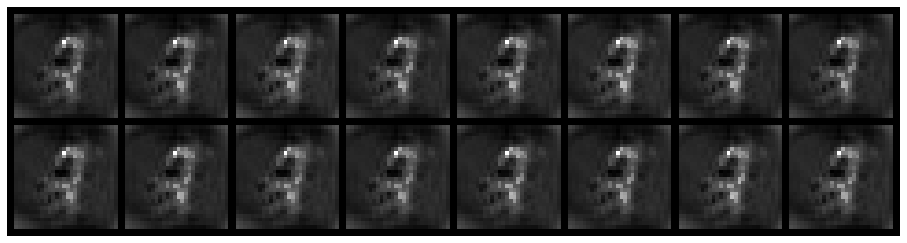

Epoch: [13/100], Batch Num: [100/400]
Discriminator Loss: 0.0991, Generator Loss: 4.7015
D(x): 0.9611, D(G(z)): 0.0348


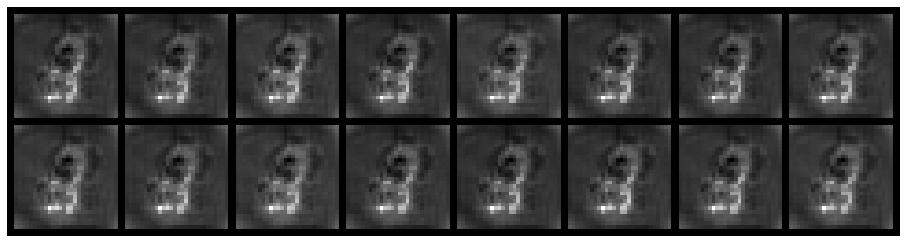

KeyboardInterrupt: 

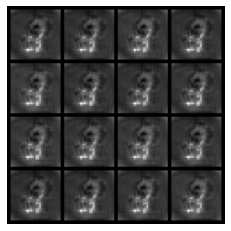

In [63]:
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 100#200

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(image_loader):
        N = real_batch.size(0)
        
        # 1. Train Discriminator
        #real_data = Variable(images_to_vectors(real_batch))
        real_batch = Variable(real_batch)
        # Generate fake data and detach (so gradients are not calculated for generator)
        fake_data = generator(noise(N).to(device)).detach()
        # Train Discriminator
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_batch.to(device), fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N).to(device))
        # Train Generator
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = generator(test_noise)
            test_images = test_images.data.to("cpu")
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

In [67]:
#Test here

#test_images = generator(test_noise)
#n_batch, (real_batch,_) = next(enumerate(image_loader))
#real_batch.shape
#plt.imshow(test_images[15][0].cpu().detach().numpy(), cmap='gray', interpolation='none')


#generator.linear1[0]
for parameter in generator.short1.parameters():
    print(parameter)


Parameter containing:
tensor([[[[-0.0133]],

         [[-0.0179]],

         [[-0.0297]],

         ...,

         [[ 0.0424]],

         [[ 0.0138]],

         [[-0.0379]]],


        [[[-0.0575]],

         [[-0.0129]],

         [[-0.0621]],

         ...,

         [[-0.0408]],

         [[ 0.0440]],

         [[ 0.0111]]],


        [[[ 0.0562]],

         [[-0.0323]],

         [[-0.0080]],

         ...,

         [[ 0.0064]],

         [[-0.0064]],

         [[ 0.0081]]],


        ...,


        [[[ 0.0152]],

         [[ 0.0329]],

         [[ 0.0077]],

         ...,

         [[-0.0278]],

         [[-0.0193]],

         [[-0.0048]]],


        [[[ 0.0136]],

         [[-0.0446]],

         [[-0.0348]],

         ...,

         [[ 0.0199]],

         [[ 0.0146]],

         [[-0.0069]]],


        [[[ 0.0307]],

         [[ 0.0504]],

         [[ 0.0381]],

         ...,

         [[ 0.0348]],

         [[-0.0152]],

         [[ 0.0039]]]], device='cuda:0', requires_grad=Tru

## Resources

* https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
* https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/

## Notes

* When using convtranspose in generator, but not conv in discriminator, after 50 epochs, genearated images are not close to the results obtained when using only linear layers.
* Generator seems to be always generating the same image even if you pass n noise samples. Parameters in first linear layers are zeroed just after first loops. After some research, this is called "mode colapse".
* To try solving this problem, I deleted one linear layer to the generator, and adjusted learning rate to 0.0005.
* Tried to use the same approach as in ResNet, which is to apply a shortcut by summing original input to last linear layer output using a conv2 to  expand the input from 100 to 540, but this approach caused to gradients in shortcut conv2 went to 0 too, causing the same effect.


## ToDo

* Try to use the approach used in resnet networks. Awnser, it seems to not be working.
* I will stop here investigation here.